**Import Libraries**

In [23]:
import os
import zipfile
from glob import glob

# Data Manipulation Libraries
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# **Step 1: Load Data**

In [24]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

In [25]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [26]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Print Dataframe**

In [27]:
labels_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,No_Finding,Path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,1,0,0,1,0,0,0,0,/cluster/home/bjorneme/projects/Data/chestX-ra...
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,1,/cluster/home/bjorneme/projects/Data/chestX-ra...
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,1,0,/cluster/home/bjorneme/projects/Data/chestX-ra...


# **Step 3: Exploratory Data Analysis (EDA)**

**Number of Unique Patients**

In [28]:
unique_patients = labels_df['Patient ID'].nunique()
print(f"Number of Unique Patients: {unique_patients}")

Number of Unique Patients: 30805


**Distribution of Disease Label**

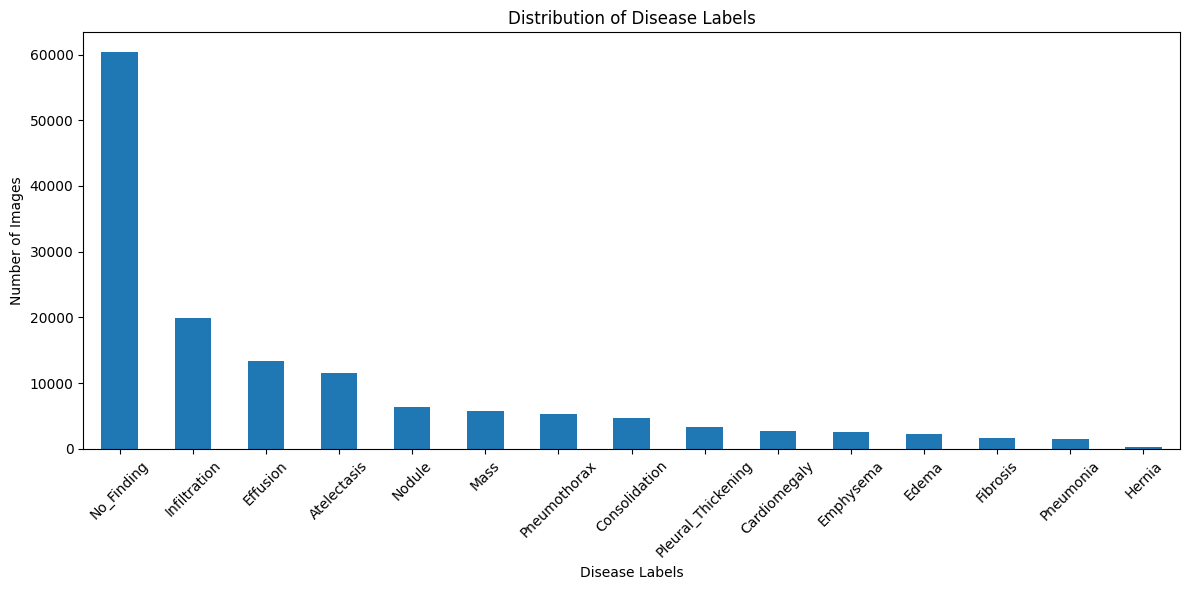

In [29]:
# Sum counts of disease labels including 'No_Finding' and sort them
label_counts = labels_df[disease_labels + ['No_Finding']].sum().sort_values(ascending=False)

# Plot the distribution
label_counts.plot(kind='bar', figsize=(12, 6), title="Distribution of Disease Labels", rot=45)
plt.xlabel("Disease Labels")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

**Distribution of Patient Age**

In [ ]:
# TODO

**Distribution of Patient Gender**

In [ ]:
# TODO

**Distribution of View Position**

In [ ]:
# TODO

**Visualize Samples**

In [ ]:
# TODO